In [1]:
# import system libs 
import os
import time
import shutil
import itertools

# import data handling tools 
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
# Generate data paths with lables 
def define_paths(dir):
    filepaths = []
    labels = []

    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Conctainate data pathes with lables into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)


# Split data into train, validation, and test
def split_data(tr_dir):
    # train and # validation dataframe 
    files, classes = define_paths(tr_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, valid_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    
    return train_df, valid_df

In [3]:
def create_model_data (train_df, valid_df, batch_size):
    
    ''' This function takes train, validation, and test dataframe and fit them into image data generator, because model takes 
         data from image data generator. 
         Image data generator converts images into tensors. '''
    

    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)
    
    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(train_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    
    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img
    
    tr_gen =ImageDataGenerator(preprocessing_function= scalar, 
                            horizontal_flip=True,
                            rotation_range=20,
                            zoom_range=0.2,
                            shear_range=0.1,
                            brightness_range=[0.8, 1.2])

    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)
    
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)
    
    # Note: we will use custom test_batch_size, and make shuffle= false
    
    
    return train_gen, valid_gen

In [4]:
def show_images(gen):
    
    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index} 
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string 
    images, labels = next(gen)        # get a batch size samples from the generator
    
    
    # calculate number of dispalyed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images
    
    plt.figure(figsize= (20, 20))
    
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        
        # note 
        index = np.argmax(labels[i])  # get image index
        
        class_name = classes[index]   # get class of image
        
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [5]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans == 'Y' or ans == 'y':
            self.ask_permission = 1
        elif ans == 'N' or ans == 'n':
            self.ask_permission = 0
        
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights) 


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100 
        loss = logs.get('loss')
        
        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '') 


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss
            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                else:
                    self.count = self.count + 1 # increment the patience counter
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)
                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training
                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch ' + str(self.ask_epoch)
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)
                        except:
                            print('Invalid')

In [6]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()


In [7]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)
	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')
	else:
		print('Confusion Matrix, Without Normalization')
	print(cm)
	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

Found 4183 validated image filenames belonging to 4 classes.
Found 1046 validated image filenames belonging to 4 classes.


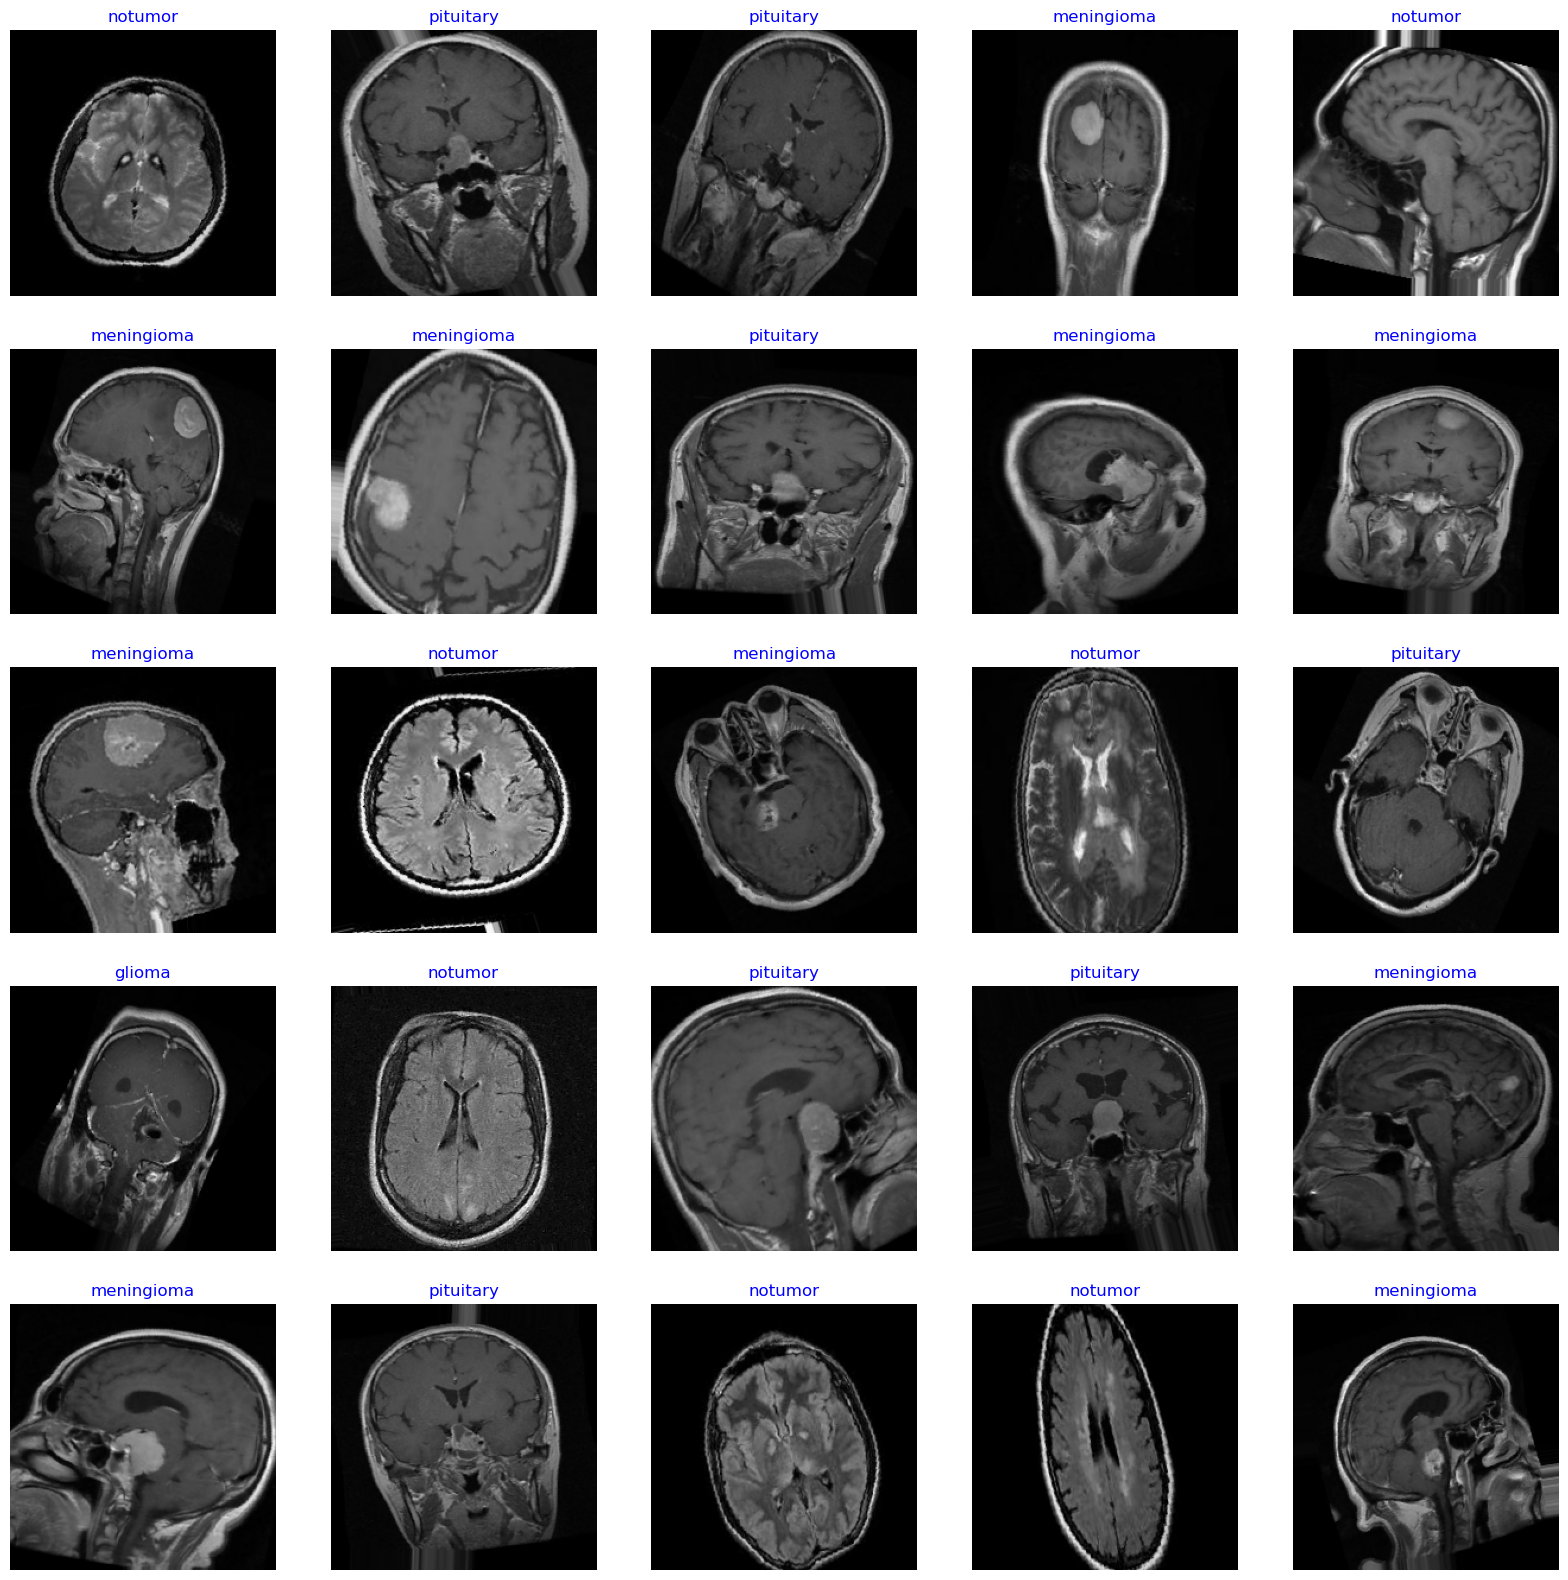

In [8]:
# Get Dataframes
train_dir = '/kaggle/input/code-to-cure-10/Training'
train_df, valid_df = split_data(train_dir)

# Get Generators
batch_size = 40
train_gen, valid_gen = create_model_data(train_df, valid_df, batch_size)

# Display Image Samples
show_images(train_gen)

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

# Define image size, channels and class count
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained base model
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')

# Build model on top of base model
model = Sequential()
model.add(base_model)
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
model.add(Dense(512, activation=None, kernel_regularizer=regularizers.l2(l=0.01), bias_regularizer=regularizers.l1(0.01)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(rate=0.5, seed=123))
model.add(Dense(256, activation=None, kernel_regularizer=regularizers.l2(l=0.01), bias_regularizer=regularizers.l1(0.01)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(rate=0.5, seed=123))
model.add(Dense(class_count, activation='softmax'))

# Compile model with appropriate optimizer, loss function and metrics
optimizer = Adamax(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print summary of model architecture
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 batch_normalization_2 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 512)               1049088   
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                      

In [14]:
batch_size = 40     # set batch size for training
epochs = 50         # number of all epochs in training
patience = 1 		    # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3 	# number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9 	  # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor = 0.5 		    # factor to reduce lr by
ask_epoch = 4		    # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, patience= patience,
            stop_patience= stop_patience, threshold= threshold, factor= factor,
            batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

In [15]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

Do you want model asks you to halt the training [y/n] ?


 y


 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /50    11.278   76.835  10.07340  85.277   0.00100  0.00100  accuracy     0.00    97.28  
 2 /50     9.168   87.497   8.64037  85.373   0.00100  0.00100  accuracy    13.88    68.61  
 3 /50     7.580   91.609   6.85166  93.881   0.00100  0.00100  val_loss    20.70    69.35  
 4 /50     6.233   94.669   5.61690  96.367   0.00100  0.00100  val_loss    18.02    69.04  
enter H to halt training or an integer for number of epochs to run then ask again


 10


 training will continue until epoch 14
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 5 /50     5.132   95.553   4.57886  96.654   0.00100  0.00100  val_loss    18.48    68.49  
 6 /50     4.153   96.653   3.72871  96.558   0.00100  0.00100  val_loss    18.57    68.47  
 7 /50     3.336   97.466   2.98017  97.228   0.00100  0.00100  val_loss    20.08    68.08  
 8 /50     2.655   97.753   2.37996  97.132   0.00100  0.00100  val_loss    20.14    68.07  
 9 /50     2.115   97.490   1.90322  96.845   0.00100  0.00100  val_loss    20.03    69.21  
10 /50     1.662   98.183   1.50844  96.845   0.00100  0.00100  val_loss    20.74    68.92  
11 /50     1.309   97.896   1.20399  96.941   0.00100  0.00100  val_loss    20.18    68.29  
12 /50     1.019   98.350   0.93071  97.419   0.00100  0.00100  val_loss    22.70    68.88  
13 /50     0.798   98.494   0.81562  95.220   0.00100  0.00100  val_loss    12.36    67.95  
14 /50     0.635   98.183   0.77

 10


 training will continue until epoch 24
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
15 /50     0.501   98.470   0.46792  97.897   0.00100  0.00100  val_loss    39.53    68.21  
16 /50     0.395   98.566   0.39775  97.323   0.00100  0.00100  val_loss    15.00    68.14  
17 /50     0.355   97.562   0.35141  97.228   0.00100  0.00100  val_loss    11.65    68.16  
18 /50     0.287   97.848   0.34898  95.698   0.00100  0.00100  val_loss     0.69    67.98  
19 /50     0.238   98.111   0.56641  90.631   0.00100  0.00050  val_loss    -62.31   68.17  
20 /50     0.193   98.613   0.21673  97.706   0.00050  0.00050  val_loss    37.89    68.83  
21 /50     0.160   99.187   0.19705  98.184   0.00050  0.00050  val_loss     9.08    68.30  
22 /50     0.139   99.450   0.28922  95.029   0.00050  0.00025  val_loss    -46.78   69.23  
23 /50     0.129   99.378   0.16925  98.184   0.00025  0.00025  val_loss    14.11    68.69  
24 /50     0.111   99.737   0.17

 10


 training will continue until epoch 34
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
25 /50     0.107   99.665   0.16318  98.375   0.00013  0.00013  val_loss     3.59    69.19  
26 /50     0.100   99.737   0.15638  98.279   0.00013  0.00013  val_loss     4.17    67.39  
27 /50     0.094   99.833   0.15028  98.375   0.00013  0.00013  val_loss     3.90    67.32  
28 /50     0.089   99.880   0.14551  98.470   0.00013  0.00013  val_loss     3.18    69.07  
29 /50     0.087   99.809   0.14705  98.375   0.00013  0.00006  val_loss    -1.06    68.79  
30 /50     0.085   99.880   0.14435  98.279   0.00006  0.00006  val_loss     0.79    69.15  
31 /50     0.081   99.761   0.13968  98.279   0.00006  0.00006  val_loss     3.24    67.94  
32 /50     0.077   99.904   0.13558  98.470   0.00006  0.00006  val_loss     2.93    68.24  
33 /50     0.077   99.833   0.13665  98.470   0.00006  0.00003  val_loss    -0.79    68.08  
34 /50     0.075   99.857   0.13

 4


 training will continue until epoch 38
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
35 /50     0.076   99.809   0.13849  98.375   0.00002  0.00001  val_loss    -2.15    67.54  
 training has been halted at epoch 35 after 3 adjustments of learning rate with no improvement
training elapsed time was 0.0 hours, 46.0 minutes, 19.66 seconds)


In [ ]:
plot_training(history)

In [ ]:
ts_length = len(train_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)


In [ ]:
    def scalar(img):
        return img

In [ ]:
preprocess_input = scalar

In [ ]:
import pandas as pd
df = pd.read_csv('/kaggle/input/code-to-cure-10/submission_attempt.csv')
l= list(df['ID'])
images = []
for i in l:
  if len(str(i)) == 1 :
    images.append("/kaggle/working/example/Testing/000"+str(i)+".jpg")
  elif len(str(i)) == 2 :
    images.append("/kaggle/working/example/Testing/00"+str(i)+".jpg")
  else :
    images.append("/kaggle/working/example/Testing/0"+str(i)+".jpg")

In [ ]:
from keras.utils import load_img
from keras.utils import img_to_array

import numpy as np

pred = []
# load and preprocess the image
for img in images :
    img_path = img
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

# predict the class probabilities
    preds = model.predict(x)
    print(np.argmax(preds))
    pred.append(np.argmax(preds))

In [ ]:
df['Label'] = pred
df.to_csv('samplesub2.csv',index=False)